# 3 Optimización de Hiperpárametros

## 3.01 Introduccion
En general los algoritmos que generan modelos predictivos poseen hiperparámetros que *dado un dataset* deben ser optimizados.
<br> La invocación de uno de esos algoritmos sin hiperparámetros no es más que
invocarlos con hiperparámetros por default definidos por el fabricante. Por ejemplo en el caso de la librería **rpart** es cp=0.01, maxdepth=30, minsplit=20, minbucket=6,  lo que en nuestro dataset genera un arbol de un solo nodo (decimos "no se abre el arbol"); la razon de esto es la proporcion de "BAJA+1" y "BAJA+2"

En el primer notebook de la asignatura usted probó optimizar manualmente los hiperparámetros entrenando en un mes completo y viendo los resultados directamente en el Public Leaderboard, que es una porción de los datos de futuro.
<br> En el mundo real no se dispone jamás de la clase del futuro, con lo cual lo anterior es meramente un artifical divertimento.
<br> La solución es estimar la bondad de un set de hiperparámetros en alguna combinación de:
  * Una sola partición de  <training, testing>
  * Multiples particiones de <training, testing>
  * El método de  k-fold Cross Validation , generalmente con n>=5
  * Utilizar   n-repated  k-fold Cross Validation
  * Leave One Out  si la cardinalidad del dataset y el poder de cómputo se lo permiten

Luego de comenzar a trabajar con el método de  "Multiples particiones de <training, testing>  se le invitó a extender un esqueleto de código del método de **Optimización de Hiperparámetros por Grid Search**

## 3.02 Conceptos

En esta entrega veremos los siguiente conceptos:
* El origen del overfitting en un arbol de decisión
* *La maldición del ganador*, overfitting en los hiperparámetros ganadores, Selective Inference
* Data Drifting
* Alterntivas de búsqueda
  * Grid Search, la fuerza bruta
  * Bayesian Optimization, la heurística

## 3.03  Corrida notebook inicial

En el repositorio oficial de la asignatura se encuentra el notebook ./src/rpart/z102_FinalTrain.ipynb  que automaticamente hace el submit a la Competencia Analista Sr  de Kaggle.
<br>  Ingrese a un nuevo Google Colab  y pruebe algunas corridas del notebook cambiando los hiperparámetros de rpart

## 3.04 Origen del Overfitting en un arbol de decisión
¿Qué combinacion de hiperparámetros overfitea un árbol de decisión, para nuestro dataset?
<br>¿Cómo se ve el overfitting desde el punto de vista de las curvas de ganancia?

El objetivo de este capítulo es que usted juegue manualmente con los hiperparámetros de un rpart, observe las curvas de ganancia generadas en una particion <training=50%, testing=50%>  y obtengla conclusiones sobre el fenómeno observado.

Introducimos el concepto de **Curva de Ganancia**
<br> Al aplicar un modelo a un dataset se le asigna a cada registro una probabilidad, a su vez cada registro contribuye con una ganancia la que puede ser una pérdida o una ganancia.  
<br>Ordenamos el dataset por probabilidad *descendente* y computamos la ganancia acumulada, generando de esta forma la curva de ganancia
<br> Para visualizar el efecto del under/over  fitting adecuadamente, realizamos una particion  <training= 50%, testing= 50%>



tener presente:
<br> Overfitting  **NO**  es la diferencia entre las curvas
<br> Lo que divide el underfitting del overfitting al aumentar la complejidad del modelo es la complejidad donde se alcanza la métrica máxima.

### ¿Qué debe hacer usted?
Probar al menos estas combinaciones:
* **Arbol crecimiento descontrolado**
   * cp= -1
   * maxdepth= 30
   * minsplit= 2
   * minbucket= 1
* Arbol talla reducida
   * cp= -1
   * maxdepth= 3
   * minsplit= 20000
   * minbucket= 10000


#### Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Type -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [ ]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo kaggle.json al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [ ]:
%%shell

mkdir -p "/content/.drive/My Drive/dm"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/dm" /content/buckets/b1

mkdir -p ~/.kaggle
cp /content/buckets/b1/kaggle/kaggle.json  ~/.kaggle
chmod 600 ~/.kaggle/kaggle.json


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/itba2025-8d0a/dataset_pequeno.csv"
archivo_destino="/content/datasets/dataset_pequeno.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/dataset_pequeno.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [2]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,663459,35.5,1439380,76.9,1286645,68.8
Vcells,1239953,9.5,8388608,64.0,1924971,14.7


In [3]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("ggplot2")

Loading required package: data.table

Loading required package: rpart

Loading required package: ggplot2



In [4]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp304"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

### Acción :  Jugar con  minsplit, minbucket y maxdepth

In [16]:
# cambiar aqui los parametros
PARAM <- list()
PARAM$semilla_primigenia <- 179573


PARAM$minsplit <- 300
PARAM$minbucket <- 20
PARAM$maxdepth <- 11

In [17]:
# particionar agrega una columna llamada fold a un dataset
#   que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(data, division, agrupa= "", campo= "fold", start= 1, seed= NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(
    function(x, y) {rep(y, x)},division, seq(from= start, length.out= length(division))))

  data[, (campo) := sample(rep(bloque,ceiling(.N / length(bloque))))[1:.N],by= agrupa]
}


In [18]:
# lectura del dataset

dataset <- fread("/content/datasets/dataset_pequeno.csv")

In [19]:
# a partir de ahora solo trabajo con 202107, el mes que tiene clase

dataset <- dataset[foto_mes == 202107] # defino donde voy a entrenar

In [20]:
# La division training/testing es 50%, 50%
#  que sea 50/50 se indica con el c(1,1)

particionar(dataset,
  division= c(1, 1),
  agrupa= "clase_ternaria",
  seed= PARAM$semilla_primigenia
)

In [21]:
# Entreno el modelo
# los datos donde voy a entrenar
# aqui es donde se deben probar distintos hiperparametros

modelo <- rpart(
  formula= "clase_ternaria ~ . -fold",
  data= dataset[fold == 1, ],
  xval= 0,
  cp= -1,
  minsplit= PARAM$minsplit,
  minbucket= PARAM$minbucket,
  maxdepth= PARAM$maxdepth
)

In [22]:
# aplico el modelo a TODOS los datos, inclusive los de training
prediccion <- predict(modelo, dataset, type= "prob")

In [23]:
# Pego la probabilidad de  BAJA+2
tb_prediccion <- dataset[, list(fold,clase_ternaria)]
tb_prediccion[, prob_baja2 := prediccion[, "BAJA+2"]]

In [24]:
# Dibujo la curva de ganancia acumulada
setorder(tb_prediccion, fold, -prob_baja2)

In [25]:
# agrego una columna que es la de las ganancias
# la multiplico por 2 para que ya este normalizada
#  es 2 porque cada fold es el 50%

tb_prediccion[, gan := 2 *ifelse(clase_ternaria == "BAJA+2", 117000, -3000)]
tb_prediccion[, ganancia_acumulada := cumsum(gan), by= fold]
tb_prediccion[, pos := sequence(.N), by= fold]

In [26]:
tb_prediccion

fold,clase_ternaria,prob_baja2,gan,ganancia_acumulada,pos
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1,CONTINUA,0.2384937,-6000,-6000,1
1,CONTINUA,0.2384937,-6000,-12000,2
1,BAJA+2,0.2384937,234000,222000,3
1,BAJA+2,0.2384937,234000,456000,4
1,BAJA+1,0.2384937,-6000,450000,5
1,CONTINUA,0.2384937,-6000,444000,6
1,BAJA+1,0.2384937,-6000,438000,7
1,CONTINUA,0.2384937,-6000,432000,8
1,CONTINUA,0.2384937,-6000,426000,9


In [27]:
# agrego una columna que es la de las ganancias
# la multiplico por 2 para que ya este normalizada
#  es 2 porque cada fold es el 50%

tb_prediccion[, gan := 2 *ifelse(clase_ternaria == "BAJA+2", 117000, -3000)]
tb_prediccion[, ganancia_acumulada := cumsum(gan), by= fold]
tb_prediccion[, pos := sequence(.N), by= fold]

In [28]:
# defino hasta donde muestra el grafico
amostrar <- 20000

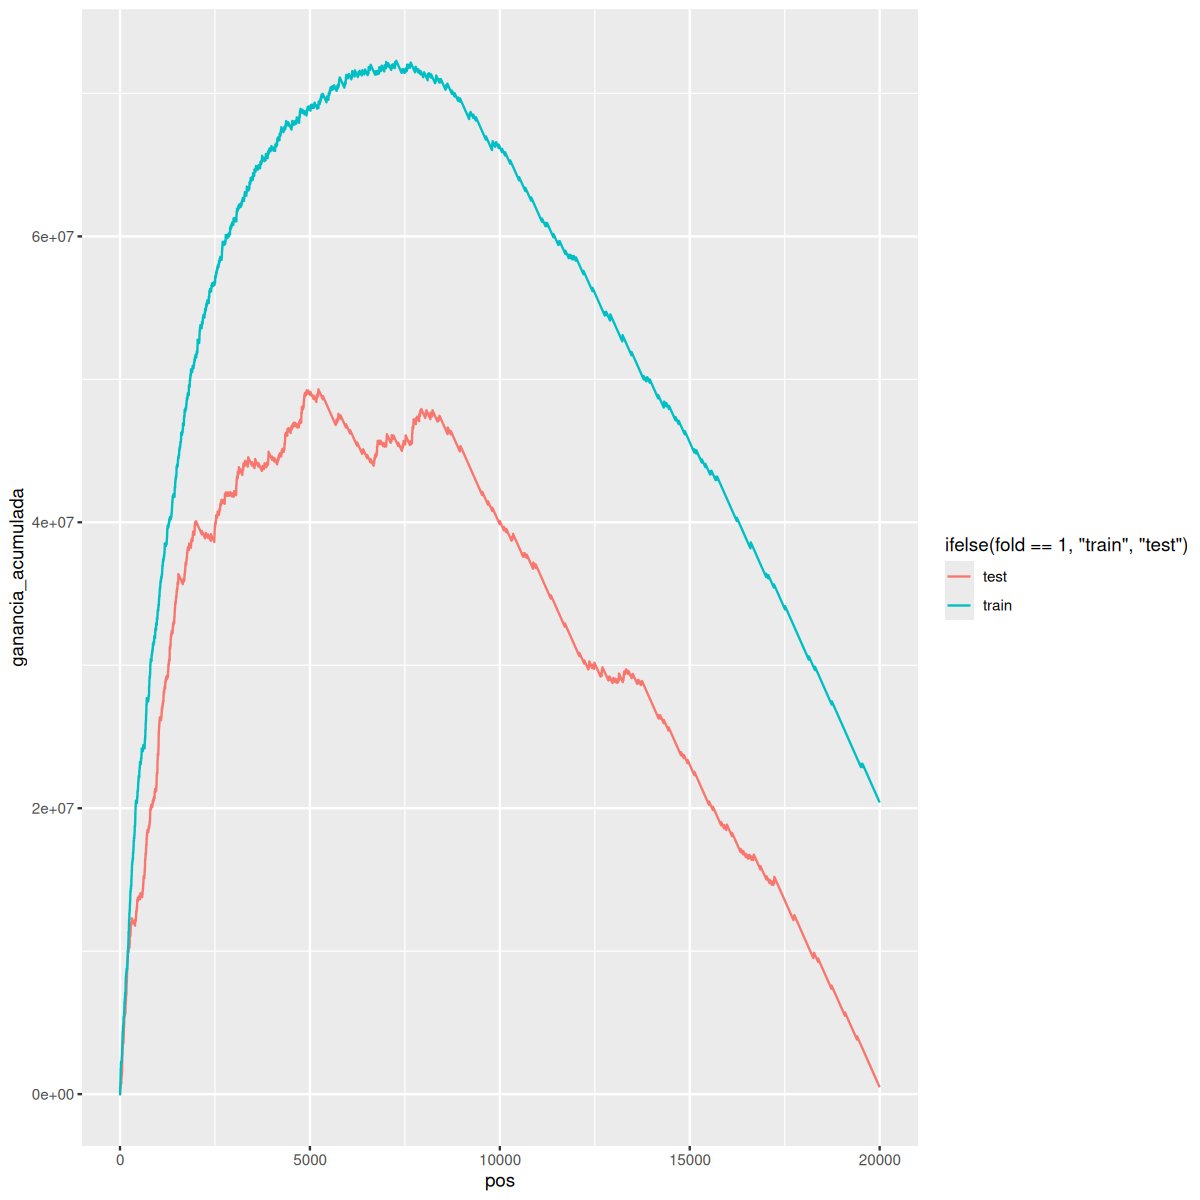

In [29]:
# Esta hermosa curva muestra como en el mentiroso training
#   la ganancia es siempre mejor que en el real testing

options( repr.plot.width=10, repr.plot.height=10)

gra <- ggplot(
           data= tb_prediccion[pos <= amostrar],
           aes( x= pos, y= ganancia_acumulada,
                color= ifelse(fold == 1, "train", "test") )
             ) + geom_line()

print( gra )


In [30]:
# veo los resultados

print(PARAM)
cat( "Train gan max: ", tb_prediccion[fold==1, max(ganancia_acumulada)], "\n" )
cat( "Test  gan max: ", tb_prediccion[fold==2, max(ganancia_acumulada)], "\n" )


$semilla_primigenia
[1] 179573

$minsplit
[1] 300

$minbucket
[1] 20

$maxdepth
[1] 11

Train gan max:  72282000 
Test  gan max:  49302000 


## 3.05 Análisis de la salida de Grid Search

En clase utilizando un enfoque constructivista de educacion cada una de las mesas del aula analizará las salidas de las corridas de Grid Search de la Tarea para el Hogar.
<br>Se espera que quienes ya trabajan como Data Analyst se luzcan en el análisis de esos datos
<br>Finalmente se utilizara un *arma conceptual secreta*, iluminando elegantemente donde están las mayores ganancias.

<br><br>Si usted no tuvo la oportunidad de hacer sus propias corridas esta generosa cátedra pone a su diposición esta salida https://storage.googleapis.com/open-courses/itba2025-8d0a/gridsearch.txt

## 3.06 La Maldición del Ganador

¿Los hiperparámetros ganadores de toda la cohorte, estan overfiteando?
<br> Trabajaremos con la hoja **C3-GS Overfitting** de la Google Sheet Colaborativa
<br> Determinar de toda la cohorte quien obtuvo la mayor ganancia y con qué hiperparámetros
<br> copiarlos  a la hoja **C3-GS Overfitting**
<br> Quien obtuvo esa ganancia no debe hacer nada
<br> El resto de la cohorte, modifica su script de Grid Search para calcular la ganancia de dichos hiperparámetros ganadores  utilizando su Semilla Primigenia y registra la ganancia en la linea correspondiente a su nombre en la hoja C3-GS Overfitting

¿ Como compara la ganancia del ganador versus el resto de las ganancias recién calculadas ?

#### Bibliografia

* Selective Inference - the silent killer of replicability   https://www.youtube.com/watch?v=6ZxIzVjV1DE
* Ioannidis, J. P. A. Why most published research findings are false. PLoS Med. 2, e124 (2005). https://journals.plos.org/plosmedicine/article/file?id=10.1371/journal.pmed.0020124&type=printable



---



## 3.07 Data Drifting  sospechas

Ordenar la salida del Grid Search en forma descendente por ganancia (en testing obviamente)
<br> De esta forma la posición 1 corresponde a la mayor ganancia, la 2 a la segunda mejor, etc
<br> En la Google Sheet Colaborativa,  hoja  **C3- GridSEarch** cargue las posiciones  1, 2, 5, 10, 50 y 100 de la salida del Grid Search, dejando la columna Public Leaderboard sin cargar
<br> La columna ganancia_mean tiene valores en orden descendente

El objetivo de hacer Grid Search  es utilizando particiones <training, testing>  encontrar los mejores hiperparámetros
<br> Esto tiene sentido en la medida que los hiperparámetros que resultan mejores de la búsqueda Grid Search son también los mejores cuando se hace el Final Training

Utilizando el notebook de la primiera clase,  **z102_FinalTrain.ipynb**   calcule para cada uno de los sets de hiperparámetros de las posiciones 1, 2, 5, 10, 50 y 100  cual es la ganancia en el Public Leaderboard de Kaggle
<br> Deberá hacer una corrida para cada conjunto de hiperparámetros

 ¿ Se cumple que los hiperparámetros de la posición  1 del Grid Search son los que mejor funcionan para predecir los datos del futuro ?

¿ Si esto no fuera así, estamos en una sitacion de **Game Over** ?



---



## 3.08 Data Drifting, breve intuicion

Se mostrará un posible origen de las discrepancias observadas en el capítulo anterior
<br> La solución al Data Drifting es otro precio ...

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [31]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,999586,53.4,2005604,107.2,2005604,107.2
Vcells,2136413,16.3,120160434,916.8,125067489,954.2


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [ ]:
# cargo las librerias que necesito
require("data.table")
require("rpart")

In [ ]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "exp308"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [ ]:
PARAM <- list()
PARAM$mes0 <- 202107
PARAM$mes1 <- 202109

In [ ]:
graficar_campo <- function(campo, param) {
  # quito de grafico las colas del 5% de las densidades
  qA <- quantile(dataset[foto_mes == param$mes0, get(campo)],
    prob= c(0.05, 0.95), na.rm= TRUE
  )

  qB <- quantile(dataset[foto_mes == param$mes1, get(campo)],
    prob= c(0.05, 0.95), na.rm= TRUE
  )

  xxmin <- pmin(qA[[1]], qB[[1]])
  xxmax <- pmax(qA[[2]], qB[[2]])

  densidad_A <- density(dataset[foto_mes == param$mes0, get(campo)],
    kernel= "gaussian", na.rm= TRUE
  )

  densidad_B <- density(dataset[foto_mes == param$mes1, get(campo)],
    kernel= "gaussian", na.rm= TRUE
  )

  plot(densidad_A,
    col= "blue",
    xlim= c(xxmin, xxmax),
    ylim= c(0, pmax(max(densidad_A$y), max(densidad_B$y))),
    main= campo
  )

  lines(densidad_B, col= "red", lty= 2)

  legend("topright",
    legend= c( param$mes0, param$mes1),
    col= c("blue", "red"), lty= c(1, 2)
  )
}


In [ ]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

In [ ]:
# Entreno el modelo
# utilizo los mejores hiperparametros encontrados

modelo <- rpart(
  formula= "clase_ternaria ~ . ",
  data= dataset[foto_mes == PARAM$mes0], # los datos donde voy a entrenar
  xval= 0,
  cp= -1,
  minsplit= 1144,
  minbucket= 539,
  maxdepth= 8
)


In [ ]:

campos_modelo <- names(modelo$variable.importance)
campos_buenos <- c(campos_modelo, setdiff(colnames(dataset), campos_modelo))
campos_buenos <- setdiff(
  campos_buenos,
  c("foto_mes", "clase_ternaria")
)

campos_buenos

In [ ]:
# para fines didacticos,  cliente_antiguedad primero
campos_buenos <- c("cliente_antiguedad", campos_buenos)

In [ ]:
# grafico las densidades de cada variable para los dos mses

options( repr.plot.width=15, repr.plot.height=15)

for (campo in campos_buenos) {
  cat(campo, "  ")
  graficar_campo(campo, PARAM)
}




---



## 3.09 Bayesian Optimization

Se explicará en clase como a partir del Grid Search se deriva el algoritmo de Bayesian Optimization



---



## 3.10 Bayesian Optimization código

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [1]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,653320,34.9,1439377,76.9,1286644,68.8
Vcells,1216878,9.3,8388608,64.0,1924971,14.7


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table** y  **rpart**

In [2]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
require("parallel")

Loading required package: data.table

Loading required package: rpart

Loading required package: parallel



In [3]:
if( ! require("rlist") ) install.packages("rlist")
require("rlist")

Loading required package: rlist



In [4]:
# paquete necesarios para la Bayesian Optimization
if( !require("DiceKriging") ) install.packages("DiceKriging")
require("DiceKriging")

Loading required package: DiceKriging



In [5]:
# paquete necesarios para la Bayesian Optimization
if( !require("mlrMBO") ) install.packages("mlrMBO")
require("mlrMBO")

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Loading required package: smoof

Loading required package: checkmate


Attaching package: ‘checkmate’


The following object is masked from ‘package:DiceKriging’:

    checkNames




Accion a realizar : cambiar por su semilla primigenia

In [6]:
# Defino la  Optimizacion Bayesiana

# cantidad de iteraciones de la Optimizacion Bayesiana
PARAM <- list()

PARAM$semilla_primigenia <- 179573
PARAM$experimento <- "HT310"

PARAM$BO_iter <- 40 #cantidad de iteraciones de la Bayesian Optimization

# la letra L al final de 1L significa ENTERO
PARAM$hs <- makeParamSet(
    makeNumericParam("cp", lower= -1, upper= 0.1),
    makeIntegerParam("minsplit", lower= 1L, upper= 8000L),
    makeIntegerParam("minbucket", lower= 1L, upper= 4000L),
    makeIntegerParam("maxdepth", lower= 3L, upper= 20L),
    forbidden= quote(minbucket > 0.5 * minsplit)
)
# minbuket NO PUEDE ser mayor que la mitad de minsplit



In [7]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
dir.create(PARAM$experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", PARAM$experimento ))

In [8]:
particionar <- function(data, division, agrupa = "", campo = "fold",
                        start = 1, seed = NA) {
  if (!is.na(seed)) set.seed(seed)

  bloque <- unlist(mapply(
    function(x, y) {
      rep(y, x)
    }, division,
    seq(from= start, length.out= length(division))
  ))

  data[, (campo) := sample(rep(bloque, ceiling(.N / length(bloque))))[1:.N],
    by= agrupa
  ]
}


In [9]:
# fold_test  tiene el numero de fold que voy a usar para testear,
#  entreno en el resto de los folds
# param tiene los hiperparametros del arbol

ArbolSimple <- function(fold_test, param_rpart) {
  # genero el modelo
  # entreno en todo MENOS el fold_test que uso para testing
  modelo <- rpart("clase_ternaria ~ .",
    data= dataset[fold != fold_test, ],
    xval= 0,
    control= param_rpart
  )

  # aplico el modelo a los datos de testing
  # aplico el modelo sobre los datos de testing
  # quiero que me devuelva probabilidades
  prediccion <- predict(modelo,
    dataset[fold == fold_test, ],
    type= "prob"
  )

  # esta es la probabilidad de baja
  prob_baja2 <- prediccion[, "BAJA+2"]

  # calculo la ganancia
  ganancia_testing <- dataset[fold == fold_test][
    prob_baja2 > 1 / 40,
    sum(ifelse(clase_ternaria == "BAJA+2",
      117000, -3000
    ))
  ]

  # esta es la ganancia sobre el fold de testing, NO esta normalizada
  return(ganancia_testing)
}


In [10]:
ArbolesCrossValidation <- function(param_rpart, qfolds, pagrupa, semilla) {
  # generalmente  c(1, 1, 1, 1, 1 )  cinco unos
  divi <- rep(1, qfolds)

  # particiono en dataset en folds
  particionar(dataset, divi, seed= semilla, agrupa= pagrupa)

  ganancias <- mcmapply(ArbolSimple,
    seq(qfolds), # 1 2 3 4 5
    MoreArgs= list(param_rpart),
    SIMPLIFY= FALSE,
    mc.cores= detectCores()
  )

  dataset[, fold := NULL]

  # devuelvo la primer ganancia y el promedio
  # promedio las ganancias
  ganancia_promedio <- mean(unlist(ganancias))
  # aqui normalizo la ganancia
  ganancia_promedio_normalizada <- ganancia_promedio * qfolds

  return(ganancia_promedio_normalizada)
}


In [11]:
# esta funcion solo puede recibir los parametros que se estan optimizando
# el resto de los parametros, lamentablemente se pasan como variables globales

EstimarGanancia <- function(x) {
  message(format(Sys.time(), "%a %b %d %X %Y"))
  GLOBAL_iteracion <<- GLOBAL_iteracion + 1

  xval_folds <- 5
  # param= x los hiperparametros del arbol
  # qfolds= xval_folds  la cantidad de folds
  ganancia <- ArbolesCrossValidation(
    param_rpart= x,
    qfolds= xval_folds,
    pagrupa= "clase_ternaria",
    semilla= PARAM$semilla_primigenia
  )

  return(ganancia)
}


In [12]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")

In [14]:

archivo_log <- "BO_log.txt"
archivo_BO <- "bayesian.RDATA"

# leo si ya existe el log
#  para retomar en caso que se se corte el programa
GLOBAL_iteracion <- 0
GLOBAL_mejor <- -Inf

if (file.exists(archivo_log)) {
  tabla_log <- fread(archivo_log)
  GLOBAL_iteracion <- nrow(tabla_log)
  GLOBAL_mejor <- tabla_log[, max(ganancia)]
}



ERROR: Error in eval(jsub, SDenv, parent.frame()): object 'ganancia' not found


In [45]:

# Aqui comienza la configuracion de la Bayesian Optimization

funcion_optimizar <- EstimarGanancia

configureMlr(show.learner.output= FALSE)

# configuro la busqueda bayesiana,
#  los hiperparametros que se van a optimizar
# por favor, no desesperarse por lo complejo
# minimize= FALSE estoy Maximizando la ganancia
obj.fun <- makeSingleObjectiveFunction(
  fn= funcion_optimizar,
  minimize= FALSE,
  noisy= TRUE,
  par.set= PARAM$hs,
  has.simple.signature= FALSE
)

ctrl <- makeMBOControl(
  save.on.disk.at.time= 600,
  save.file.path= archivo_BO
)

ctrl <- setMBOControlTermination(ctrl, iters= PARAM$BO_iter)
ctrl <- setMBOControlInfill(ctrl, crit= makeMBOInfillCritEI())

surr.km <- makeLearner("regr.km",
  predict.type= "se",
  covtype= "matern3_2", control= list(trace= TRUE)
)


In [ ]:

# inicio la optimizacion bayesiana
if (!file.exists(archivo_BO)) {
  bayesiana_salida <- mbo(
    fun= obj.fun,
    learner= surr.km,
    control= ctrl
  )
} else {
  bayesiana_salida <- mboContinue(archivo_BO)
}
# retomo en caso que ya exista


Computing y column(s) for design. Not provided.

Sat Jul 19 15:17:54 2025



In [ ]:
# almaceno los resultados de la Bayesian Optimization
# y capturo los mejores hiperparametros encontrados

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)

# ordeno en forma descendente por AUC = y
setorder(tb_bayesiana, -y)

# grabo para eventualmente poder utilizarlos en OTRA corrida
fwrite( tb_bayesiana,
  file= "BO_log.txt",
  sep= "\t"
)

# los mejores hiperparámetros son los que quedaron en el registro 1 de la tabla
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[
  1, # el primero es el de mejor AUC
  list(cp, minsplit, minbucket, maxdepth)
]

print(PARAM$out$lgbm$mejores_hiperparametros)

In [ ]:
format(Sys.time(), "%a %b %d %X %Y")



---

